#  Предсказание цен на нефть по новостям в твиттере
Имеем два датасета: датасет цен на нефть марки Brent типа open-high-low-close chart в период с 09.12.2017 по 01.07.2019 с периодичностью в 5 минут и датасет всех твитов, содержащих ключевые слова (oil,brent), некоторых новостных изданий ('Bloomberg', 'CNN Breaking News', 'Financial Times', 'MarketWatch', 'Reuters Top News', 'The Economist', 'The Wall Street Journal', 'The Washington Post', 'Thomson Reuters').

#### Основная задача: 
построить модель, способную по новостям из твиттера предсказывать динамику цены на нефть.

In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import datetime
# Preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MODELS
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
#import catboost as cat


%matplotlib inline

Для начала внимательно взглянем на наши начальные данные.

In [314]:
prices = pd.read_csv('oil.csv', delimiter = ',' , parse_dates={'datetime':[2,3]})

prices = prices.drop(columns=['<TICKER>', '<PER>'])

prices = prices.rename(columns={'<OPEN>':'open', 
                       '<HIGH>':'high', 
                       '<LOW>':'low', 
                       '<CLOSE>':'close',
                       '<VOL>':'vol'})
prices.head()

,datetime,open,high,low,close,vol
0,2017-12-09 00:05:00,63.41,63.41,63.33,63.33,68
1,2017-12-09 00:10:00,63.34,63.35,63.34,63.35,55
2,2017-12-09 00:15:00,63.35,63.36,63.34,63.36,41
3,2017-12-09 00:20:00,63.35,63.35,63.32,63.32,31
4,2017-12-09 00:25:00,63.33,63.36,63.33,63.34,59


In [315]:
tweets = pd.read_csv('oil_tweets.csv', parse_dates={'datetime':[3,4]})
tweets['datetime'] = tweets['datetime'].dt.floor('5min') # уберем секунды у твитов
tweets.head(2)

,datetime,id,conversation_id,created_at,timezone,user_id,username,name,place,tweet,...,likes_count,hashtags,cashtags,link,retweet,quote_url,video,user_rt_id,near,geo
0,2019-06-30 22:55:00,1145466269212270593,1145466269212270593,1561935414000,UTC,5988062,theeconomist,The Economist,NaN,Mudslides have cut off Colombia's food and oil...,...,62,[],[],https://twitter.com/TheEconomist/status/114546...,NaN,NaN,0,NaN,NaN,NaN
1,2019-06-30 21:50:00,1145449674511458305,1145449674511458305,1561931458000,UTC,34713362,business,Bloomberg,NaN,OPEC+ nations are close to finalizing a “chart...,...,23,[],[],https://twitter.com/business/status/1145449674...,NaN,NaN,0,NaN,NaN,NaN


Найдем для каждого пятиминутного open максимальный, минимальный close в течении следующего часа. Затем посмотрим на разницу между найдеными максимальными и минимальными знаечниями, и высчитаем их среднее. Это среднее - самая простая целевая переменная, которую можно было бы использовать для какой-нибудь регрессионной модели. Большое по модулю значение говорит о сильном росте или спаде цены на нефть в течении последующего часа, в зависимости от знака. 

In [316]:
T = 12
prices_clear = prices.copy()
prices['max_close'] = prices.close.rolling(T).max().dropna().reset_index()['close']
prices['min_close'] = prices.close.rolling(T).min().dropna().reset_index()['close']
prices ['dif_max'] = (prices.max_close - prices.open.reset_index()['open']) 
prices['dif_min'] = (prices.min_close - prices.open.reset_index()['open'])
prices['dif'] = (prices.dif_max + prices.dif_min)/2

Что не учитывает такая переменная? Неизвестно, как именно вели себя котировки в этот час. Мы лишь можем говорить об экстремумах в определенный интервал времени. Возможно нефть скакнула в самом начале часа, а мы среагируем только под конец, где будет находиться min_close - играя на бирже с таким подходом мы рискуем потерять все наши деньги.

Наша переменная хорошо должна работать в случае, когда dif_min и dif_max одного знака. В идеале, значение одного из признаков должно стоять достаточно далеко от нуля. Это говорит нам о том, что цена не "скакала", а почти монотонно возрастала, либо убывала, в зависимости от знака. 

Вообще говоря, мы должны понимать смысл новстей и то, как они влияют на рынок. Нам не интересно, как ведут себя цены каждые пять минут. Нас интересует большой рост, которые будут длиться как минимум несколько часов. Мы не сможем точно сказать, на каком моменте рост прекратится, но предсказывать общую тенденцию - вот наша цель. 
Принимая во внимание вышесказанное, мы будем искать dif на раннем этапе, промежуточном и долгосрочном: час, два часа, 4 часа. Затем мы берем усредненное значение трех, если конечный dif будет больше по модулю заранее определенной положительной дельты, следовательно рассматриваемая пятиминутка будет иметь положительную или отрицательную "окраску", то есть либо цена повышается, либо снижается, иначе нейтральную.

In [317]:
T = 24
prices['max_close'] = prices.close.rolling(T).max().dropna().reset_index()['close']
prices['min_close'] = prices.close.rolling(T).min().dropna().reset_index()['close']
prices ['dif_max'] = (prices.max_close - prices.open.reset_index()['open']) 
prices['dif_min'] = (prices.min_close - prices.open.reset_index()['open'])
prices['dif1'] = (prices.dif_max + prices.dif_min)/2
T = 48
prices['max_close'] = prices.close.rolling(T).max().dropna().reset_index()['close']
prices['min_close'] = prices.close.rolling(T).min().dropna().reset_index()['close']
prices ['dif_max'] = (prices.max_close - prices.open.reset_index()['open']) 
prices['dif_min'] = (prices.min_close - prices.open.reset_index()['open'])
prices['dif2'] = (prices.dif_max + prices.dif_min)/2

prices['dif'] = prices.dif+prices.dif1+prices.dif2

In [318]:
prices.drop(['max_close','min_close','dif_max','dif_min','dif1','dif2'],axis=1,inplace=True)
prices = prices.dropna()

prices = prices.set_index('datetime')
tweets = tweets.set_index('datetime')

prices.close = prices.close.sort_index()
prices = prices.loc[:'2019-07-02',:]

In [319]:
prices.head()

,open,high,low,close,vol,dif
datetime,,,,,,
2017-12-09 00:05:00,63.41,63.41,63.33,63.33,68,-0.42
2017-12-09 00:10:00,63.34,63.35,63.34,63.35,55,-0.21
2017-12-09 00:15:00,63.35,63.36,63.34,63.36,41,-0.22
2017-12-09 00:20:00,63.35,63.35,63.32,63.32,31,-0.22
2017-12-09 00:25:00,63.33,63.36,63.33,63.34,59,-0.16


Какую дельту для определения порога нейтральности мы возьмем? Очевидно, что задача должна быть на несбалансированные классы, где нейтральные новости должны существенно преобладать.
Выборочная медиана выборки prices.dif равна -0.029625, выборочная дисперсия 0.45368. 

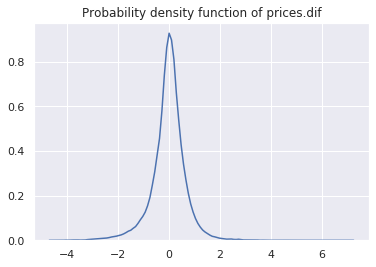

mean   -0.029625
std     0.673561
min    -4.565000
25%    -0.320000
50%     0.005000
75%     0.310000
max     7.100000
Name: dif, dtype: float64


In [320]:
sns.kdeplot(prices.dif.values)
plt.title('Probability density function of prices.dif')
plt.show()
print(prices.dif.describe()[1:])

In [321]:
mean = prices.dif.values.mean()
var = prices.dif.values.var()
prices['target'] = prices.dif.apply(lambda x: 2 if x > mean+var else 1 if x <mean-var else 0)
prices.target.value_counts()

0    67170
2    19961
1    18773
Name: target, dtype: int64

При таком разделении преобладание нейтральных новостей не будет достаточно явным. Наша задача состоит в поиске "аномальных" новостей, которые сильно повлияют на котировки. К тому же рост в 45 центов это конечно много, но не достаточно надежно. Поэтому возьмем двойную дисперсию.

In [322]:
prices['target'] = prices.dif.apply(lambda x: 2 if x > mean+2*var else 1 if x <mean-2*var else 0)
prices.target.value_counts()

0    91770
1     7878
2     6256
Name: target, dtype: int64

##### Выглядит неплохо, правильно ли вообще подобрана переменная? Рассмотрим один частный случай.

In [323]:
# Приджоиним к твитам цены, чтобы наложить потом на график котировок
# CREATE TABLE news 
# AS
# SELECT p.close, t.replies_count, t.retweets_count, t.likes_count, t.tweet
# FROM tweets t INNER JOIN prices p
# ON t.datetime = p.datetime

news = tweets.join(prices, how='inner')[['close','replies_count', 'retweets_count', 'likes_count', 'tweet','dif','target']]

In [324]:
news.head()

,close,replies_count,retweets_count,likes_count,tweet,dif,target
datetime,,,,,,,
2017-12-11 02:40:00,63.15,0,34,29,-Asia stocks mixed -Yen falls to lowest in a m...,-0.180,0
2017-12-11 05:20:00,63.03,16,57,68,Oil prices drop on increased U.S. drilling act...,0.190,0
2017-12-11 05:30:00,63.08,10,47,36,Saudi Aramco executives see ride-sharing as th...,0.130,0
2017-12-11 05:30:00,63.08,1,13,10,Norway’s dilemma over an oil fund without oil ...,0.130,0
2017-12-11 07:20:00,63.14,1,27,25,Oil is around $57 after U.S. drillers add rigs...,0.115,0


Напишем небольшую функцию, рисующую график котировок, а также наиболее залайканные новости.

In [325]:
def likes_range(start, end, likes_thr,plot=False):
    

    tmp = news[news['likes_count'] >= likes_thr]
    tmp = tmp.loc[start:end,'close']
    
    if plot:
        plt.figure(figsize=(16,10))
        plt.plot(prices.loc[start:end,'close'], alpha=0.8, zorder=1)
        plt.scatter(tmp.index, tmp, c='red', alpha=0.5, zorder=2)

        plt.xlim(pd.to_datetime(start),pd.to_datetime(end))
        plt.show()
    
    return tmp

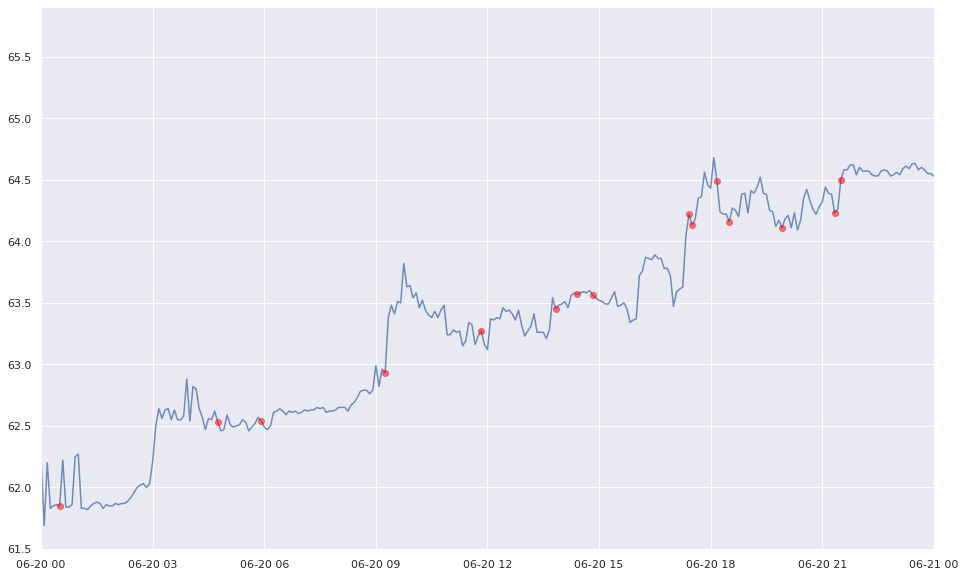

datetime
2019-06-20 00:30:00    61.85
2019-06-20 04:45:00    62.53
2019-06-20 05:55:00    62.54
2019-06-20 09:15:00    62.93
2019-06-20 11:50:00    63.27
2019-06-20 13:50:00    63.45
2019-06-20 14:25:00    63.57
2019-06-20 14:50:00    63.56
2019-06-20 17:25:00    64.22
2019-06-20 17:30:00    64.13
2019-06-20 18:10:00    64.49
2019-06-20 18:30:00    64.16
2019-06-20 19:55:00    64.11
2019-06-20 21:20:00    64.23
2019-06-20 21:30:00    64.50
2019-06-21 00:30:00    64.59
2019-06-21 00:45:00    64.65
2019-06-21 03:05:00    64.76
2019-06-21 04:00:00    64.85
2019-06-21 04:15:00    64.89
2019-06-21 04:20:00    64.85
2019-06-21 05:00:00    64.89
2019-06-21 08:05:00    64.40
2019-06-21 08:35:00    64.21
2019-06-21 08:50:00    64.21
2019-06-21 10:40:00    64.66
2019-06-21 11:05:00    64.79
2019-06-21 11:25:00    64.95
2019-06-21 12:50:00    64.81
2019-06-21 13:20:00    65.30
2019-06-21 13:20:00    65.30
2019-06-21 13:30:00    65.49
2019-06-21 13:40:00    65.57
2019-06-21 14:00:00    65.68
2019-

In [326]:
likes_range('2019-06-20', '2019-06-21', likes_thr=100,plot=True)

Что такого примечательного в дате 20.06.2019? В этот день Иранские войска сбили американский беспилотник, на что рынок нефти незамедлительно отреагировал. Смотрим дату новости и сопоставляем ее с графиком.

In [327]:
print(tweets[tweets['likes_count'] > 100]['2019-06-20 00' : '2019-06-20 12' ]['tweet'])
print()
print('09:15:00')
print(tweets[tweets['likes_count'] > 100]['2019-06-20 00' : '2019-06-20 12' ]['tweet'].iloc[1])

datetime
2019-06-20 11:50:00    U.S. confirms Iran shot down U.S. drone, addin...
2019-06-20 09:15:00    Iran shoots down a U.S. Navy drone, the latest...
2019-06-20 05:55:00    Iran's elite Revolutionary Guards claimed to h...
2019-06-20 04:45:00    A U.S. military spokesman declined to comment ...
2019-06-20 00:30:00    Opinion: American allies no longer trust the w...
Name: tweet, dtype: object

09:15:00
Iran shoots down a U.S. Navy drone, the latest in a series of skirmishes in the Middle East that have stoked fears of a wider military conflict  https://on.wsj.com/2Y07zJP 


Слухи подтвердились, беспилотник действительно был сбит. После этой новости цена на нефть увеличилась почти на доллар. Причем официальное подтверждение от правительства США никак не повлияло на цены, потому что рынок уже успел среагировать. 

Взглянем внимательно на нижний датасет. Утром лишь указанная нами и отмеченная на графике новость имеет target=2, что означает положительный окрас новости. Если внимательнее просмотреть весь день, можно соотнести также новость о повышении цен на нефть Норвегией и соответственно положительный окрас этой новости. Или же новость о сборе лидеров конгресса по вопросу с Ираном и сбитым беспилотником, рынок снова отреагировал.

In [328]:
news.loc['2019-06-20 04':'2019-06-20 15',:]

,close,replies_count,retweets_count,likes_count,tweet,dif,target
datetime,,,,,,,
2019-06-20 04:45:00,62.53,30,81,149,A U.S. military spokesman declined to comment ...,-0.130,0
2019-06-20 04:55:00,62.47,1,18,27,Iran claims it shot down US drone over its air...,0.290,0
2019-06-20 05:45:00,62.52,8,29,51,Energy companies are grappling with sophistica...,0.575,0
2019-06-20 05:50:00,62.57,0,11,18,Iran says it shot down U.S. drone amid rising ...,0.670,0
2019-06-20 05:55:00,62.54,161,276,570,Iran's elite Revolutionary Guards claimed to h...,0.550,0
2019-06-20 06:00:00,62.49,0,19,22,"Oil prices rise as U.S. stockpiles drop, OPEC ...",0.580,0
2019-06-20 06:30:00,62.62,9,54,69,Iran said it shot down a U.S. spy drone in its...,0.635,0
2019-06-20 08:25:00,62.69,30,51,86,Iran shoots down U.S. naval drone in Persian G...,1.535,2
2019-06-20 09:15:00,62.93,8,45,42,Oil prices jump as downed U.S. drone stokes Mi...,1.245,2


##### Для уверенности глянем еще один пример.

In [329]:
tweets[tweets['likes_count'] > 80]['2019-06-13 00':'2019-06-13 12']['tweet']

datetime
2019-06-13 12:30:00    Iran supreme leader says he has no intention t...
2019-06-13 12:25:00    Here's the latest on the suspected attack on o...
2019-06-13 12:20:00    It's worth asking who benefits from the attack...
2019-06-13 12:20:00    Crude prices climbed sharply after an attack o...
2019-06-13 12:15:00    The damage to one of two tankers that came und...
2019-06-13 11:20:00    The suspected attack on oil tankers in the Gul...
2019-06-13 10:45:00    Oil tankers attacked in Gulf of Oman, U.S. Nav...
2019-06-13 10:10:00    U.S. Navy responds to suspected attacks on two...
2019-06-13 10:05:00    UPDATE: Two oil tankers hit in suspected attac...
2019-06-13 09:10:00    Iran supreme leader says has no intention to m...
2019-06-13 09:05:00    A British maritime safety body said it was inv...
2019-06-13 08:10:00    Here's what we know so far about the suspected...
2019-06-13 07:45:00    Oil surges after report of tanker incident in ...
2019-06-13 07:10:00    MORE: Two oil tanke

Все тот же июнь того же года, только новость была на неделю раньше. На часах 06:30 утра - горит танкер с нефтью, меньше чем через час еше одна новость: загорелся второй танкер. Реакция рынка:

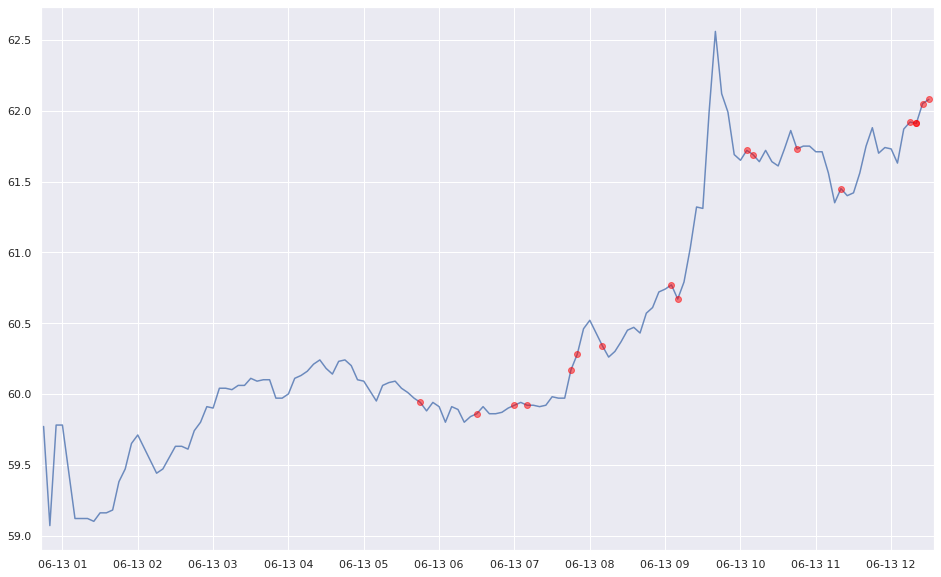

datetime
2019-06-13 05:45:00    59.94
2019-06-13 06:30:00    59.86
2019-06-13 07:00:00    59.92
2019-06-13 07:10:00    59.92
2019-06-13 07:45:00    60.17
2019-06-13 07:50:00    60.28
2019-06-13 08:10:00    60.34
2019-06-13 09:05:00    60.77
2019-06-13 09:10:00    60.67
2019-06-13 10:05:00    61.72
2019-06-13 10:10:00    61.69
2019-06-13 10:45:00    61.73
2019-06-13 11:20:00    61.45
2019-06-13 12:15:00    61.92
2019-06-13 12:20:00    61.91
2019-06-13 12:20:00    61.91
2019-06-13 12:25:00    62.05
2019-06-13 12:30:00    62.08
Name: close, dtype: float64

In [330]:
likes_range('2019-06-13 00:43:00', '2019-06-13 12:34:00', likes_thr=80,plot=True)

In [331]:
news.loc['2019-06-13 00':'2019-06-13 12',:]

,close,replies_count,retweets_count,likes_count,tweet,dif,target
datetime,,,,,,,
2019-06-13 00:40:00,59.77,6,40,52,Africa is the top spot for Chinese oil investm...,-0.745,0
2019-06-13 01:25:00,59.10,18,23,18,"Saudi Arabia says that Iran is ""spreading chao...",1.355,2
2019-06-13 02:20:00,59.47,0,9,6,Oil prices firm while stocks fall in Asia trad...,1.045,2
2019-06-13 02:35:00,59.63,3,9,18,"Asian stocks subdued, oil near five-month low ...",0.820,0
2019-06-13 02:40:00,59.61,4,16,21,"After a 7-day rally, global equities are showi...",0.790,0
2019-06-13 03:00:00,59.90,0,2,5,Opec must confront an unpalatable reality htt...,0.335,0
2019-06-13 04:00:00,60.00,0,16,25,Oil extends decline after slump on high invent...,0.460,0
2019-06-13 04:15:00,60.16,7,53,69,The U.S. Treasury Department imposed sanctions...,-0.145,0
2019-06-13 05:15:00,60.06,1,19,23,"Oil holds near lows on U.S. stockpile build, p...",0.355,0


Первая новость появилась в 6 утра, пиковой цены нефть достигла почти через 4 часа. То есть рынок отреагировал не так скоро, возможно ожидалось подвтерждение от более крупных изданий. Но наш окрас оказался положительным для самой первой новости про танкер. Срегировав именно на нее и вовремя покинув рынок, мы бы выручили свыше 2.5 доллара за каждый баррель.

### Построение модели

Нами решается NLP-задача мультиклассовой классификации. Для начала подготовим наши данные.

In [332]:
news.tweet = news.tweet.apply(lambda x: x[:x.find('http')-2].lower()) # обрезаем гиперссылки и url картинок
size_max = news.tweet.map(lambda x: len(x)).values.max() #максимальная длина новости в нашем датасете